### Description - Time Dependent model

Utiliza todo o conjunto de dados ``train.csv`` para fazer a previsão daquele mês em diante. Utiliza as estratégias de previsão Multioutput, DirecRec e Direct.

Objetivo de criar um arquivo para **submeter no kaggle** e avaliar a performance.


### Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from random import sample
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from statsmodels.tsa.api import ExponentialSmoothing
from warnings import simplefilter
simplefilter("ignore")

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure",
       autolayout=True,
       figsize=(8,4),
       titlesize=18,
       titleweight='bold',
      )
plt.rc("axes",
       labelweight="bold",
       labelsize="large",
       titleweight="bold",
       titlesize=16,
       titlepad=10,
      )
plot_params = dict(color="0.75",
                   style=".-",
                   markeredgecolor="0.25",
                   markerfacecolor="0.25",
                  )
%config InlineBackend.figure_format = 'retina'


### Load datasets

In [3]:
cols = ["cfips", "microbusiness_density", "active"]
train_df = pd.read_csv('./files/train.csv',
                      usecols=["first_day_of_month"] + cols,
                      parse_dates=['first_day_of_month'],
                      index_col='first_day_of_month',
                      ).to_period('D').reindex(columns=cols)

train_df.index.names = ['Month']
# train_df = train_df.drop("active", axis=1)

print(train_df.info())
train_df.head(3)

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 122265 entries, 2019-08-01 to 2022-10-01
Freq: D
Data columns (total 3 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   cfips                  122265 non-null  int64  
 1   microbusiness_density  122265 non-null  float64
 2   active                 122265 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 3.7 MB
None


,cfips,microbusiness_density,active
Month,,,
2019-08-01,1001,3.007682,1249
2019-09-01,1001,2.884870,1198
2019-10-01,1001,3.055843,1269


In [4]:
test_df = pd.read_csv('./files/test.csv')
test_df['first_day_of_month'] = pd.to_datetime(test_df['first_day_of_month'])

samp_sub_df = pd.read_csv('./files/sample_submission.csv')

# econ_rates = pd.read_csv('./files/economic_rates.csv',
#                          sep=';',
#                          parse_dates=['Month'],
#                          index_col='Month',
#                         ).to_period('D')

# for col in econ_rates.columns: econ_rates[col] = econ_rates[col].str.replace(',', '.').astype(np.float64) 
# display(econ_rates.head(3))
# display(test_df.head(3))
# display(samp_sub_df.head(3))


#### Pivoted dataframe

In [5]:
# make pivot, setting date by index and cfips in columns
train_pivoted = train_df.drop('active', axis=1).pivot_table(index='Month', columns='cfips', values='microbusiness_density')
train_pivoted.tail()

cfips,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
Month,,,,,,,,,,,,,,,,,,,,,
2022-06-01,3.346197,8.507496,1.191678,1.275998,1.773202,0.937421,1.983687,2.724583,1.468978,1.117345,...,1.713062,6.101229,3.212966,113.19935,7.739897,2.783238,25.652266,3.906035,3.126551,1.803249
2022-07-01,3.437971,8.573463,1.216926,1.326588,1.831783,0.950089,2.042414,2.782648,1.548280,1.141118,...,1.766595,6.191458,3.184532,114.09351,7.884691,2.836282,25.939260,3.981813,3.225807,1.803249
2022-08-01,3.423852,8.491150,1.196728,1.292861,1.836289,0.962757,2.107667,2.788231,1.521846,1.131609,...,1.766595,6.221535,3.156099,113.44169,7.779387,2.811320,26.085369,3.974924,3.209264,1.785395
2022-09-01,3.442677,8.341701,1.206827,1.315346,1.852060,0.975424,2.166395,2.809447,1.502964,1.131609,...,1.766595,6.178568,3.170316,128.26224,7.792550,2.811320,26.090586,3.995591,3.209264,1.785395
2022-10-01,3.463856,8.359798,1.232074,1.287240,1.831783,0.988092,2.185970,2.800514,1.442544,1.117345,...,1.713062,6.217238,3.212966,227.75665,7.792550,2.823801,26.273220,4.009369,3.126551,1.785395


### Last Value Baseline

In [6]:
U = train_df.reset_index().sort_values(by='Month')
last_target = U.groupby('cfips').tail(1)[['cfips', 'microbusiness_density']]

last_target_dict = dict(zip(last_target['cfips'].values,
                            last_target['microbusiness_density'].values
                           )
                       )
test_df['microbusiness_density'] = test_df['cfips'].map(last_target_dict)
test_df[['row_id', 'microbusiness_density']].to_csv('./submission_files/lastvalue_baseline.csv', index=False)


### Population Calculation

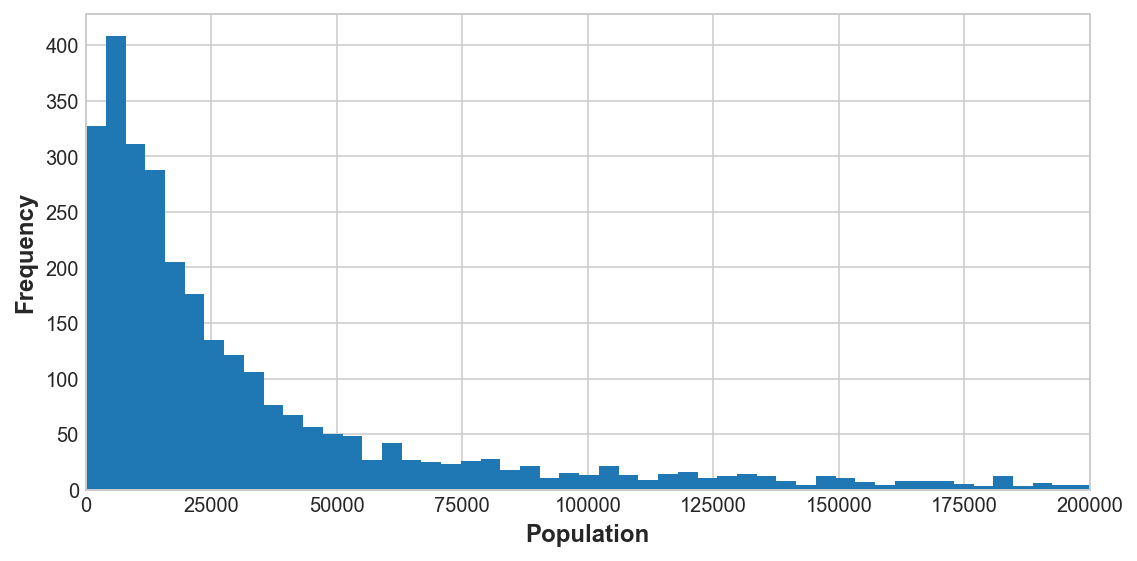

In [7]:
train_df['population'] = round(100*train_df['active']/train_df['microbusiness_density'], 0)
train_df['population'] = train_df['population'].fillna(method="ffill").astype(np.int64)

train_df.groupby('cfips')['population'].mean().plot(kind='hist', bins=2000, figsize=(8,4))
plt.xlim(0,200e3)
plt.xlabel('Population')
plt.show();

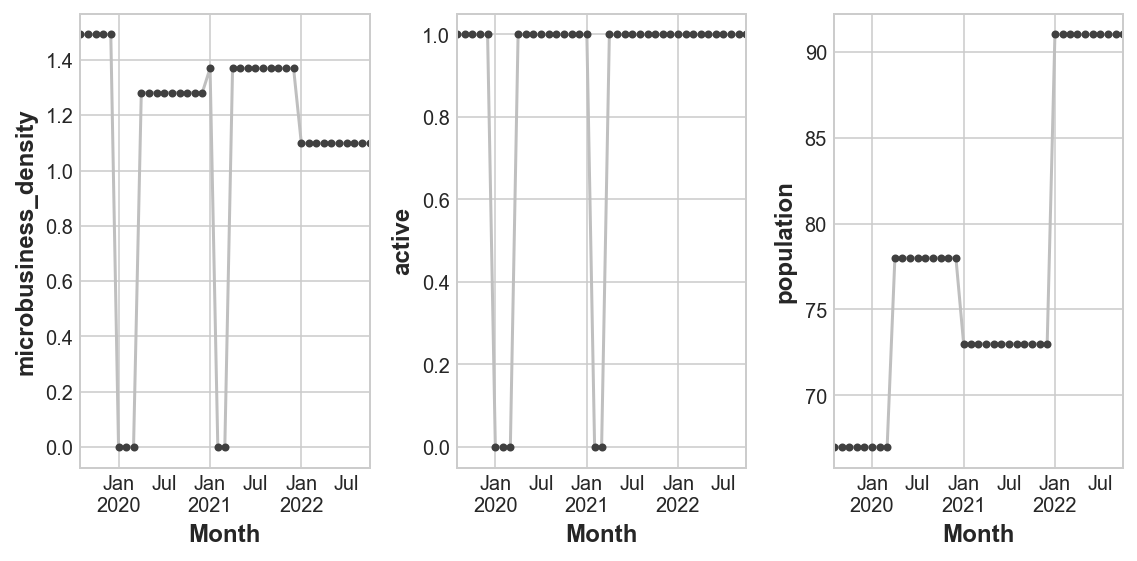

In [8]:
cfip=48301
df = train_df.loc[train_df['cfips'] == cfip]

fig, axs = plt.subplots(1,3)
df['microbusiness_density'].plot(**plot_params, ax=axs[0], ylabel='microbusiness_density')
df['active'].plot(**plot_params, ax=axs[1], ylabel='active')
df['population'].plot(**plot_params, ax=axs[2], ylabel='population');


In [9]:
avg_population = train_df.groupby('cfips')[['population']].mean().sort_values('population', ascending=False)
# avg_population.head()
pop_year = train_df[['cfips','population']]
pop_year['year'] = pop_year.reset_index()['Month'].dt.year.values
pop_year['month'] = pop_year.reset_index()['Month'].dt.month.values
pop_year.head(3)

,cfips,population,year,month
Month,,,,
2019-08-01,1001,41527,2019,8
2019-09-01,1001,41527,2019,9
2019-10-01,1001,41527,2019,10


#### Population 2021 - Used to calculate microbusiness_density of year 2023

In [10]:
use_cols = ['GEO_ID', 'NAME', 'DP05_0021E']
pop_2021 = pd.read_csv('./files/ACSDP5Y2021.DP05-Data.csv',
                       usecols=use_cols,
                      ).drop(0, axis=0)

pop_2021.head(3)

,GEO_ID,NAME,DP05_0021E
1,0500000US01001,"Autauga County, Alabama",44438
2,0500000US01003,"Baldwin County, Alabama",178105
3,0500000US01005,"Barbour County, Alabama",19995


In [11]:
# Change columns name
pop_2021.columns = ['geo_id', 'county_name', 'population_2021']
pop_2021['population_2021'] = pop_2021['population_2021'].astype(np.int64)
pop_2021['geo_id'] = pop_2021['geo_id'].str.split('S', expand=True)[1]
pop_2021['geo_id'] = pop_2021['geo_id'].astype(np.int64)
pop_2021.head(3)

,geo_id,county_name,population_2021
1,1001,"Autauga County, Alabama",44438
2,1003,"Baldwin County, Alabama",178105
3,1005,"Barbour County, Alabama",19995


#### DataFrame of population - forecast period

In [12]:
# take the population of year 2022
pop_2022 = pop_year[(pop_year['year'] == 2022) & (pop_year['month'] == 2)]
pop_2020_dict = dict(zip(pop_2022['cfips'].values, pop_2022['population'].values))

# dicionary with values population by cfips in 2023 
pop_2021_dict = dict(zip(pop_2021['geo_id'].values, pop_2021['population_2021'].values))

# Map the population to the test_df dataframe
pop_forecast = test_df.copy()
pop_forecast['year'] = pop_forecast['first_day_of_month'].dt.year.values

pop_forecast_2022 = pop_forecast[pop_forecast['year'] == 2022]
pop_forecast_2023 = pop_forecast[pop_forecast['year'] == 2023]

pop_forecast_2022['population'] = pop_forecast_2022['cfips'].map(pop_2020_dict)
pop_forecast_2023['population'] = pop_forecast_2023['cfips'].map(pop_2021_dict)

pop_forecast = pd.concat([pop_forecast_2022, pop_forecast_2023], axis=0)

# dataframe with the respective population by year and cfips
test_df = test_df.merge(pop_forecast[['row_id','population']], how="left", on="row_id")
test_df.head(3)


,row_id,cfips,first_day_of_month,microbusiness_density,population
0,1001_2022-11-01,1001,2022-11-01,3.463856,42496
1,1003_2022-11-01,1003,2022-11-01,8.359798,171296
2,1005_2022-11-01,1005,2022-11-01,1.232074,19804


### Active Analysis

In [13]:
# average active businesses in each cfip
avg_active = train_df.groupby('cfips')[['active']].mean().sort_values(by='active', ascending=False)
active_over2000 = avg_active[avg_active >= 2000]
active_under2000 = avg_active[avg_active < 2000]
print(len(active_over2000), len(active_under2000))

3135 3135


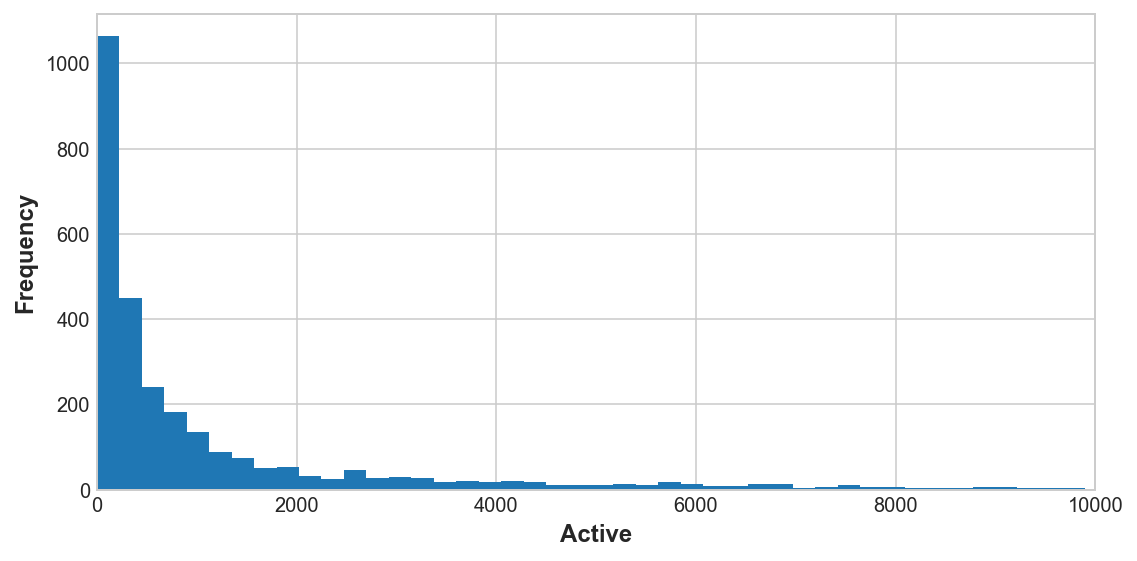

In [14]:
active_grouped = train_df.groupby('cfips')[['active']].mean()
active_grouped.plot(kind='hist', bins=5000, figsize=(8,4))
plt.xlim(0, 10e3)
plt.xlabel('Active')
plt.legend([])
plt.show();

#### Divide cfips in classes by nº active_businesses

(log_mean, log_std):  (6.4308492512682935, 2.0094165966087854)
(std_low, std_sup):  (4.421432654659508, 8.440265847877079)
(2*std_low, 2*std_sup):  (2.412016058050723, 10.449682444485864)


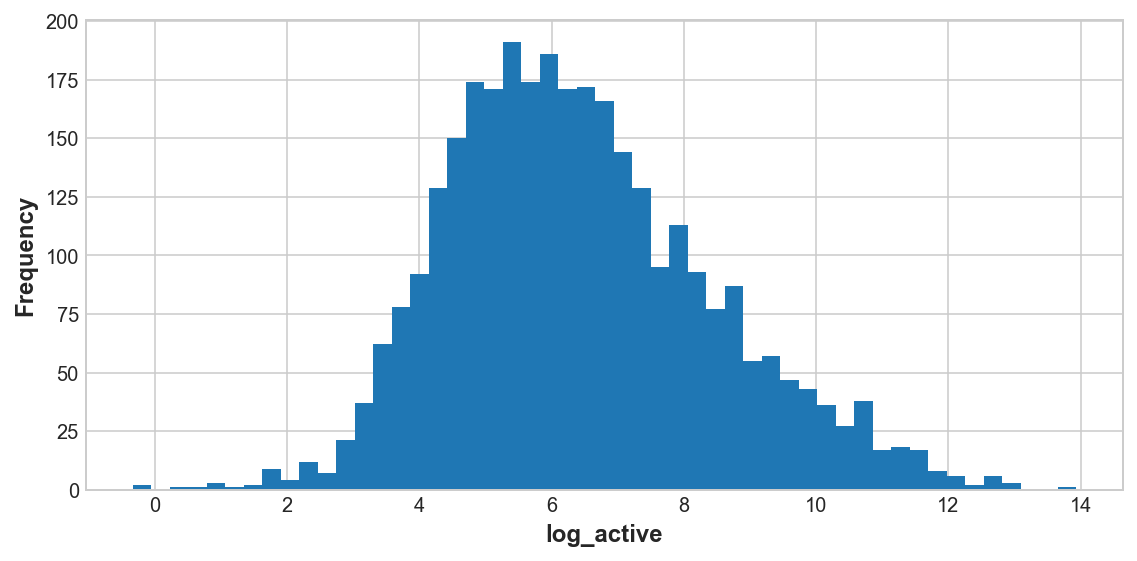

In [15]:
log_active_grouped = pd.Series(np.log(active_grouped.values.flatten()), index=active_grouped.index)

(log_mean, log_std) = (log_active_grouped.mean(), log_active_grouped.std())
(std_low, std_sup) = (log_mean - log_std, log_mean + log_std)
(std2_low, std2_sup) = (log_mean - 2*log_std, log_mean + 2*log_std)

print('(log_mean, log_std): ', (log_mean, log_std))
print('(std_low, std_sup): ', (std_low, std_sup))
print('(2*std_low, 2*std_sup): ', (std2_low, std2_sup))

log_active_grouped.plot(kind='hist', bins=51, figsize=(8,4))
plt.xlabel('log_active')
plt.show();

In [16]:
active_grouped['class'] = pd.cut(active_grouped.squeeze(),
                                 bins=[0, np.exp(std2_low), np.exp(std_low), np.exp(log_mean),
                                       np.exp(std_sup), np.exp(std2_sup), np.inf],
                                 labels=['extra_low', 'low', 'med_low',
                                         'med_high', 'high', 'extra_high'])

active_grouped.head(3)

,active,class
cfips,,
1001,1331.717949,med_high
1003,13064.538462,high
1005,222.102564,med_low


In [17]:
active_grouped['class'].value_counts()

med_low       1251
med_high       912
low            427
high           383
extra_high     129
extra_low       33
Name: class, dtype: int64

### Functions and Models

#### R2 linear regression

In [18]:
def R2_metric(df, ts_df):
    
    R2_error = []

    for cfip in df.index:

        ts = ts_df.loc[ts_df.cfips == cfip]
        
        # Fit linear regression on the period of fev-2021 and forward
        x = np.arange(18,39).reshape(21,1)
        y = ts['active'].iloc[18:]
        model = LinearRegression().fit(x, y)
        R2_error.append(model.score(x,y))

    df['R2_fev2021_forward'] = R2_error
    
    return df.sort_values('R2_fev2021_forward', ascending=False)

#### Submission File

In [19]:
def sub_file(df_test, df_pred):
    
    # assert row_id by cfip active in pred_forecast dataframe
    df_pred = pd.concat({'active': df_pred}, names=[None, 'cfips'], axis=1)
    df_pred = df_pred.stack().reset_index()    
    df_pred["Month"] = df_pred["Month"].astype(str)
    df_pred["cfips"] = df_pred["cfips"].astype(str)
    df_pred["row_id"] = df_pred["cfips"] + "_" + df_pred["Month"]    
    df_pred = df_pred.drop(["Month", "cfips"], axis=1).reindex(columns=['row_id', 'active'])
    
    # map the population in the forecast dataframe and calculate the microbusiness_density
    pop_dict = dict(zip(df_test['row_id'], df_test['population']))
    df_pred['population'] = df_pred['row_id'].map(pop_dict)
    df_pred['microbusiness_density'] = 100 * df_pred['active'] / df_pred['population']
    df_pred = df_pred[['row_id', 'microbusiness_density']]
    
    # take the row_id's on df_test that donn´t are in df_pred 
    df_test = df_test[['row_id', 'microbusiness_density']]
    orign_microb = df_test[~df_test['row_id'].isin(df_pred['row_id'])]
    
    sub_final = df_test[['row_id']].merge(pd.concat([orign_microb, df_pred], axis=0), how="left", on="row_id")
    empty_values = sub_final.isna().sum().sum()
    
    return empty_values, sub_final


#### Linear Regression model

In [20]:
def adj_linearregression_model(error_class_df, ts_class_df):
    
    # dataframe with forecasteds values
    pred_forecast = pd.DataFrame(index=pd.date_range('2022-11-01', '2023-06-01', freq='MS'))
    pred_forecast.index.names = ["Month"]

    for cfip in error_class_df.index[:50]:

        df = ts_class_df[ts_class_df['cfips'] == cfip]

        # Fit linear regression on the period of fev-2021 and forward
        x = np.arange(18,39).reshape(21,1)
        x_fore = np.arange(39,47).reshape(8,1)
        y = df['active'].iloc[18:]

        model = LinearRegression().fit(x, y)

        linreg_fit = pd.Series(model.predict(x), index=y.index)
        linreg_fore = pd.Series(model.predict(x_fore), index=pd.date_range('2022-11-01', '2023-06-01', freq='MS'))

        # Adjust trend starting from the last point
        y_fore_adj = (model.coef_[0])*(x_fore - 38) + y.iloc[-1]
        linreg_fore_adj = pd.Series(y_fore_adj.flatten(), index=linreg_fore.index)

        pred_forecast[cfip] = linreg_fore_adj

    return pred_forecast.clip(0.0)


#### Exponencial Smoothing model

Direct-recursive forecasting strategy with clipping by std()


In [21]:
def clip_exp_smoothing_model(error_class_df, ts_class_df):
    
    # dataframe with forecasteds values
    pred_forecast = pd.DataFrame(index=pd.date_range('2022-11-01', '2023-06-01', freq='MS'))
    pred_forecast.index.names = ["Month"]

    for cfip in error_class_df.index[:]:

        df = ts_class_df[ts_class_df['cfips'] == cfip].copy()
        df.index = df.index.to_timestamp()
        df = df['active'].iloc[18:]
        mean_var = df.iloc[18:].pct_change().mean() # mean variation of values
        std_var = df.iloc[18:].pct_change().std()  # standard deviation of values

        ets_fore = []
        for _ in range(1, 9):  #number of forecasts is 8, so will loop 8 times

            model = ExponentialSmoothing(df, trend='mul', damped_trend=True, seasonal=None,
                                         seasonal_periods=12, initialization_method='estimated',
                                        ).fit()#optimized=True,
                                               #use_brute=True,
                                               #remove_bias=True,
                                               #method='bh')

            forecast = model.forecast(1).clip(lower= df[-1]*(1 + mean_var - std_var),
                                              upper= df[-1]*(1 + mean_var + std_var))

            df = pd.concat([df, forecast], axis=0)
            ets_fore.append(forecast)

        pred_forecast[cfip] = pd.concat(ets_fore, axis=0)

    return pred_forecast.clip(0.0)


#### Multiclass model

In [22]:
def lm_model(cfip, error_class_df, ts_class_df, fore_period):
    
    df = ts_class_df[ts_class_df['cfips'] == cfip].copy()

    # Fit linear regression on the period of fev-2021 and forward
    x = np.arange(18,39).reshape(21,1)
    x_fore = np.arange(39,47).reshape(8,1)
    y = df['active'].iloc[18:]
    model = LinearRegression().fit(x, y)

    linreg_fit = pd.Series(model.predict(x), index= y.index)
    linreg_fore = pd.Series(model.predict(x_fore), index= fore_period)

    # Adjust trend starting from the last point
    y_fore_adj = (model.coef_[0])*(x_fore - 38) + y.iloc[-1]
    linreg_fore_adj = pd.Series(y_fore_adj.flatten(), index= linreg_fore.index)    
    
    return linreg_fore_adj


In [23]:
def ets_model(cfip, error_class_df, ts_class_df, fore_period):
    
    df = ts_class_df[ts_class_df['cfips'] == cfip].copy()
    df.index = df.index.to_timestamp()
    df = df['active'].iloc[18:]
    mean_var = df.iloc[18:].pct_change().mean() # mean variation of values
    std_var = df.iloc[18:].pct_change().std()  # standard deviation of values

    ets_fore = []
    for _ in range(len(fore_period)):  #number of forecasts is 8, so will loop 8 times

        model = ExponentialSmoothing(df, trend='add', damped_trend=True, seasonal=None,
                                     seasonal_periods=12, initialization_method='estimated',
                                    ).fit()#optimized=True,
                                           #use_brute=True,
                                           #remove_bias=True,
                                           #method='bh')

        forecast = model.forecast(1).clip(lower= df[-1]*(1 + mean_var - std_var),
                                          upper= df[-1]*(1 + mean_var + std_var))

        df = pd.concat([df, forecast], axis=0)
        ets_fore.append(forecast)

    return pd.concat(ets_fore, axis=0)


In [24]:
def lv_model(cfip, error_class_df, ts_class_df, fore_period):
    
    last_value = pd.Series(index= fore_period, name= cfip)
    
    df = ts_class_df[ts_class_df['cfips'] == cfip].copy()
    df = df['active']
    last_value.loc[:] = df[-1]
    
    return last_value

In [25]:
def multiclass_model(error_class_df, ts_class_df):
    
    # dataframe with forecasteds values
    fore_period = pd.date_range('2022-11-01', '2023-06-01', freq='MS')
    pred_forecast = pd.DataFrame(index= fore_period)
    pred_forecast.index.names = ["Month"]

    for cfip in error_class_df.index:
        
        # take best model setted for each cfip
        model = error_class_df.loc[cfip, 'model']
        
        if model == 'linreg':            
            pred_forecast[cfip] = lm_model(cfip, error_class_df, ts_class_df, fore_period)
        
        elif model == 'ets_add_true_none':
            pred_forecast[cfip] = ets_model(cfip, error_class_df, ts_class_df, fore_period)
        
        else:
            pred_forecast[cfip] = lv_model(cfip, error_class_df, ts_class_df, fore_period)
            
    return pred_forecast.clip(0.0)


### Extract cfips by class

In [26]:
#extract cfips by class
# classes_df = active_grouped[active_grouped['class'].isin(['extra_high', 'high'])].sort_values(by='active', ascending=False)

# # time series for each cfips in df
# ts_df = train_df.loc[train_df['cfips'].isin(df.index)]

# df = R2_metric(classes_df, ts_df)

# # download the data
# df.to_csv('./files/cfips_high-extrahigh_class.csv', index=True, header=True)

# Plot
# df['R2_fev2021_forward'].clip(0.8).hist(bins=41);
# U = df.loc[df.R2_fev2021_forward > 0.95]
# len(U)

# for i in U.index[:]:
#     ts_df.loc[ts_df.cfips==i, 'active'].plot(**plot_params, title=f'{i}')
#     plt.show()
# U.head(30)

### 1 - "Extra High" class forecasting

####  Previous analysis

In [39]:
extra_high = active_grouped[active_grouped['class'] == 'extra_high'].sort_values(by='active', ascending=False)
print('extra_high shape: ', extra_high.shape)
extra_high.head(3)

extra_high shape:  (129, 2)


,active,class
cfips,,
6037,1.124174e+06,extra_high
4013,4.676466e+05,extra_high
36061,4.601021e+05,extra_high


Looking the consolidated plot, we see a clear upper trend (linear or exponential like), but no clear seasonality!


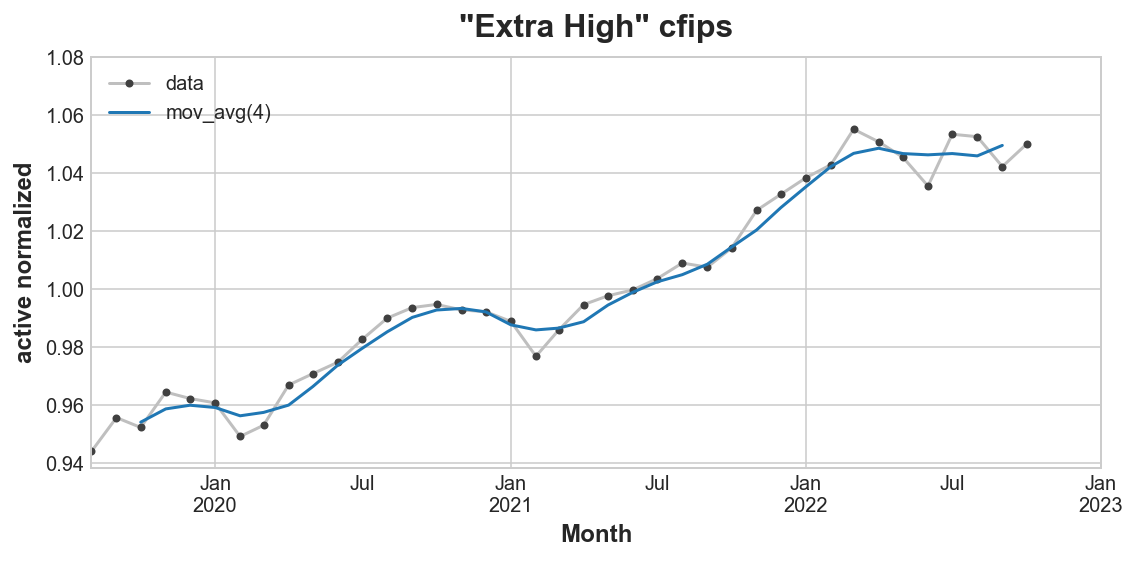

In [40]:
# filter the cfips extra high in the train_df dataset
ts_extrahigh = train_df[train_df['cfips'].isin(extra_high.index)]
ts_extrahigh['active_mean'] = ts_extrahigh.groupby('cfips')['active'].transform('mean')
ts_extrahigh['active_norm'] = ts_extrahigh['active'] / ts_extrahigh['active_mean']

ts_extrahigh.groupby('Month')['active_norm'].mean().plot(**plot_params, ylabel='active normalized', title='"Extra High" cfips', label='data')
ts_extrahigh.groupby('Month')['active_norm'].mean().rolling(4, center=True).mean().plot(label='mov_avg(4)')
plt.xlim(None, '2023-01-01')
plt.ylim(None, 1.08)
plt.legend(loc='upper left');
print("Looking the consolidated plot, we see a clear upper trend (linear or exponential like), but no clear seasonality!")

#### R² linear_regression error

In [41]:
R2_error = []

for cfip in extra_high.index:
    
    df = ts_extrahigh[ts_extrahigh['cfips'] == cfip]
    
    # Fit linear regression on the period of fev-2021 and forward
    x = np.arange(18,39).reshape(21,1)
    y = df['active'].iloc[18:]
    model = LinearRegression().fit(x, y)
    R2_error.append(model.score(x,y))

extra_high['R2_error_fev2021'] = R2_error
extra_high = extra_high.sort_values('R2_error_fev2021', ascending=False)
extra_high['group_type'] = pd.cut(extra_high['R2_error_fev2021'], bins=[0, .8, 1], labels=['outlier', 'not_outlier'])
extra_high['group_type'].value_counts()

not_outlier    95
outlier        34
Name: group_type, dtype: int64

In [42]:
dt = ts_extrahigh.groupby('cfips')['microbusiness_density'].mean().sort_values(ascending=False).copy()
extra_high['microbusiness_density'] = extra_high.index.map(dt)
extra_high[['R2_error_fev2021','microbusiness_density']]


,R2_error_fev2021,microbusiness_density
cfips,,
12011,0.988029,18.382557
48157,0.985685,11.058170
31055,0.983485,11.045280
9001,0.978971,14.733599
6111,0.976011,14.970667
...,...,...
41051,0.104176,10.975497
12001,0.050915,21.545587
8031,0.023476,16.378688


In [ ]:
','.join([str(i) for i in extra_high.index])

#### Linear regression - Forecasting

In [ ]:
linreg_forecast = adj_linearregression_model(extra_high, ts_extrahigh)
emp_vals, sub_df = sub_file(test_df, linreg_forecast)

# save submmission file
# sub_df.to_csv('./submission_files/submission_timedep_linregadj_extrahigh_80plus_v1.csv', header=True, sep=",", index=False)

print("Empty values in submission file: ", emp_vals)
sub_df.head()

#### Exponential Smoothing - Forecasting

In [ ]:
ets_forecast = clip_exp_smoothing_model(extra_high, ts_extrahigh)
emp_vals, sub_df = sub_file(test_df, ets_forecast)

# save submmission file
# sub_df.to_csv('./submission_files/submission_timedep_ets-clip-extrahigh_80plus_v0.csv', header=True, sep=",", index=False)

print("Empty values in submission file: ", emp_vals)
sub_df.head()

#### Plot predictions

In [ ]:
# Plot forecasts
# for cfip in lista.index:
cfip = 48157
df = ts_extrahigh[ts_extrahigh['cfips'] == cfip]['active']
df.plot(**plot_params, ylabel='active', label='data', title=f'{cfip}')
df.rolling(4, center=True).mean().plot(style='-', label='mov_avg')
linreg_forecast[cfip].plot(color='C1', style='.-', label='linreg_fore')
ets_forecast[cfip].plot(color='C5', style='.-', label='ets_fore_DirecRec')
plt.legend()
plt.show();

In [ ]:
# for ets with parameters trend='add', damped_trend='True', seasonal=None
# 
ets_out_list = [12011, 9001, 6111, 36059, 6001, 40143, 47037, 42003, 25017, 24033, 17197, 10005, 25025, 34013, 48339, 6067,
                48439, 6061, 39035, 12095, 36081, 17043, 13067, 49035, 36047, 34023, 6059, 51059, 36029, 42029, 24005, 39049,
                8013, 42017, 36061, 34025, 13121, 8059, 41067, 29095, 42091, 36103, 9009, 4019, 6071, 13089, 12009, 17031,
                6081, 25021, 55025, 24031, 26163, 53061, 26125, 32510, 41051, 8031]

last_value_out_list = [48453, 36055, 34027, 10003, 16001]

ets_out_dic = dict(zip(ets_out_list, ['ets_add_true_none']*len(ets_out_list)))
last_value_out_dic = dict(zip(last_value_out_list, ['last_value']*len(last_value_out_list)))

# create the column with the better model to use in forecasting
extra_high['model'] = extra_high.index.map({**ets_out_dic, **last_value_out_dic})
extra_high['model'] = extra_high['model'].fillna('linreg')
extra_high.head(3)

In [ ]:
extra_high.model.value_counts()

#### "Extra_High" multiclass forecasting

In [ ]:
extrahigh_forecast = multiclass_model(extra_high, ts_extrahigh)
emp_vals, sub_df = sub_file(test_df, extrahigh_forecast)

# save submmission file
# sub_df.to_csv('./submission_files/submission_timedep_multiclass_extrahigh_v1.csv', header=True, sep=",", index=False)

print("Empty values in submission file: ", emp_vals)
sub_df.head()

### 2 - "High" class forecasting

#### Previous Analysis

In [43]:
high = active_grouped[active_grouped['class'] == 'high'].sort_values(by='active', ascending=False)
print('high shape: ', high.shape)
high.head(3)

high shape:  (383, 2)


,active,class
cfips,,
32031,34503.666667,high
26099,34496.897436,high
34039,34014.153846,high


Looking the consolidated plot, we see a clear upper trend (exponential or quadratic like), but no clear seasonality!


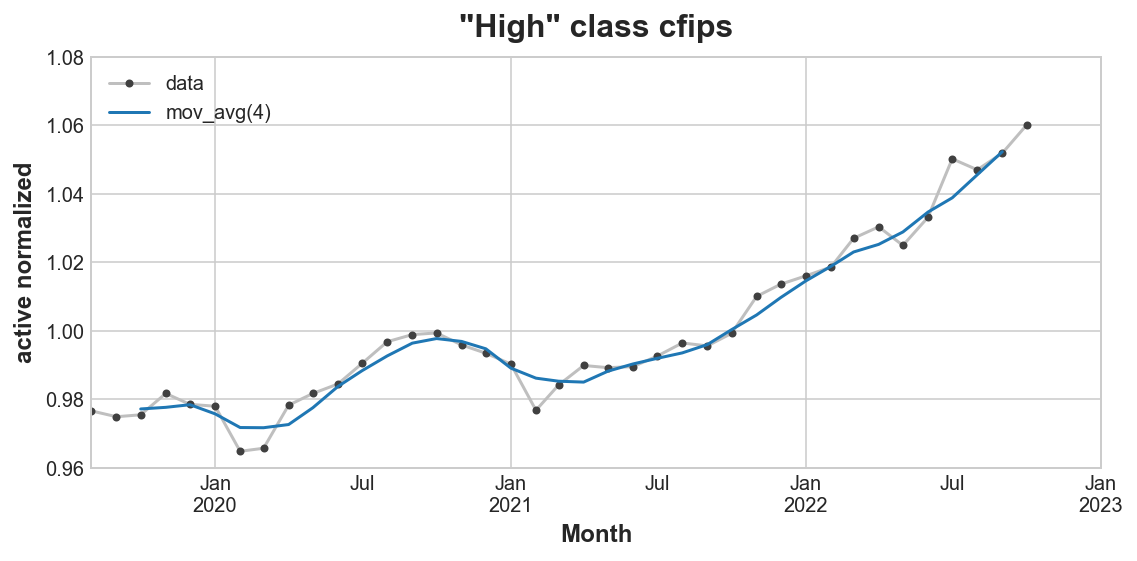

In [44]:
# filter the high class cfips in the train_df dataset, taking the time series of each them
ts_high = train_df[train_df['cfips'].isin(high.index)]
ts_high['active_mean'] = ts_high.groupby('cfips')['active'].transform('mean')
ts_high['active_norm'] = ts_high['active'] / ts_high['active_mean']

ts_high.groupby('Month')['active_norm'].mean().plot(**plot_params, ylabel='active normalized', title='"High" class cfips', label='data')
ts_high.groupby('Month')['active_norm'].mean().rolling(4, center=True).mean().plot(label='mov_avg(4)')
plt.xlim(None, '2023-01-01')
plt.ylim(None, 1.08)
plt.legend(loc='upper left');
print("Looking the consolidated plot, we see a clear upper trend (exponential or quadratic like), but no clear seasonality!")

#### R² linear_regression error

In [45]:
R2_error = []

for cfip in high.index:
    
    df = ts_high[ts_high['cfips'] == cfip]
    
    # Fit linear regression on the period of fev-2021 and forward
    x = np.arange(18,39).reshape(21,1)
    y = df['active'].iloc[18:]
    model = LinearRegression().fit(x, y)
    R2_error.append(model.score(x,y))

high['R2_error_fev2021'] = R2_error
high = high.sort_values('R2_error_fev2021', ascending=False)
high['group_type'] = pd.cut(high['R2_error_fev2021'], bins=[0, .85, 1], labels=['outlier', 'not_outlier'])
high['group_type'].value_counts()

not_outlier    214
outlier        169
Name: group_type, dtype: int64

In [55]:
dt = ts_high.groupby('cfips')['microbusiness_density'].mean().sort_values(ascending=False).copy()
high['microbusiness_density'] = high.index.map(dt)
df = high[['R2_error_fev2021','microbusiness_density']].sort_values('microbusiness_density', ascending=False)
df = df.loc[(df['R2_error_fev2021'] >= 0.7) & (df['microbusiness_density'] >= 4.0)]
df

,R2_error_fev2021,microbusiness_density
cfips,,
8105,0.830913,60.942899
41061,0.884792,54.522958
19101,0.959263,39.112656
37175,0.957453,28.956531
56039,0.887961,26.337935
...,...,...
36083,0.830445,4.101805
28121,0.862890,4.091396
37147,0.935005,4.089866


In [ ]:
','.join([str(i) for i in high.index])

#### Linear regression forecasting

In [ ]:
linreg_forecast = adj_linearregression_model(high, ts_high)
emp_vals, sub_df = sub_file(test_df, linreg_forecast)

# save submmission file
# sub_df.to_csv('./submission_files/submission_timedep_linregadj_high_50plus_v1.csv', header=True, sep=",", index=False)

print("Empty values in submission file: ", emp_vals)
sub_df.head(3)

#### Exponential Smoothing forecast

In [ ]:
ets_forecast = clip_exp_smoothing_model(high, ts_high)
emp_vals, sub_df = sub_file(test_df, ets_forecast)

# save submmission file
# sub_df.to_csv('./submission_files/submission_timedep_ets-clip-high_255plus_v0.csv', header=True, sep=",", index=False)

print("Empty values in submission file: ", emp_vals)
sub_df.head()

#### Weighted Average forecast

In [ ]:
fore_period = pd.date_range('2022-11-01', '2023-06-01', freq='MS')
rmse_lr = [mean_squared_error(linreg_forecast[cfip], lv_model(cfip, high, ts_high, fore_period), squared=False) \
           for cfip in high.index]
rmse_ets = [mean_squared_error(ets_forecast[cfip], lv_model(cfip, high, ts_high, fore_period), squared=False) \
           for cfip in high.index]

alpha_ets = np.array(rmse_ets) / (np.array(rmse_ets) + np.array(rmse_lr))


In [ ]:
weighted_forecast = alpha_ets * linreg_forecast.values + (1.0 - alpha_ets) * ets_forecast.values
weighted_forecast = pd.DataFrame(weighted_forecast, index= fore_period, columns= high.index)
weighted_forecast.index.name = 'Month'
weighted_forecast.head(3)

In [ ]:
emp_vals, sub_df = sub_file(test_df, weighted_forecast)

# save submmission file
# sub_df.to_csv('./submission_files/submission_timedep_class_high_weighted_v0.csv', header=True, sep=",", index=False)

print("Empty values in submission file: ", emp_vals)
sub_df.head()

#### Plot predictions

In [ ]:
# Plot forecasts
cfip = 18163
df = ts_high[ts_high['cfips'] == cfip]['active']
df.plot(**plot_params, ylabel= 'active', label= 'data', title= f'{cfip}')
df.rolling(4, center=True).mean().plot(style= '-', label= 'mov_avg')
weighted_forecast[cfip].plot(color= 'C6', style= '.-', label= 'weighted_fore')
linreg_forecast[cfip].plot(color= 'C1', style= '.-', label= 'linreg_fore')
ets_forecast[cfip].plot(color= 'C5', style= '.-', label= 'ets_fore_DirecRec')
plt.legend(loc='upper left')
plt.show();

In [ ]:
high.iloc[:75]

In [ ]:
# for ets with parameters trend='add', damped_trend='True', seasonal=None
# specials cfips:
# ALL OUTLIER CFIPS THAT DON´T ARE IN THE LISTS BELOW, IS ets_add_true_none GROUP_TYPE
linreg_out_list = [18057, 55101, 56033, 40017, 13117, 39151, 15007, 29077, 17167] 
last_value_out_list = [12017, 18157, 36091]

linreg_out_dic = dict(zip(linreg_out_list, ['linreg']*len(linreg_out_list)))
last_value_out_dic = dict(zip(last_value_out_list, ['last_value']*len(last_value_out_list)))

# # create the column with the better model to use in forecasting
high['model'] = high.index.map({**linreg_out_dic, **last_value_out_dic})
high['model'] = high['model'].fillna('linreg')
high.model.value_counts()
high.head(3)

#### "High" class forecasting

In [ ]:
high_forecast = multiclass_model(high, ts_high)
emp_vals, sub_df = sub_file(test_df, high_forecast)

# save submmission file
sub_df.to_csv('./submission_files/submission_timedep_multiclass_high_v0.csv', header=True, sep=",", index=False)

print("Empty values in submission file: ", emp_vals)
sub_df.head()

### 3 - "Med_High" class forecasting

#### Previous Analysis

In [50]:
med_high = active_grouped[active_grouped['class'] == 'med_high'].sort_values(by='active', ascending=False)
print('med_high shape: ', med_high.shape)
med_high.head(3)

med_high shape:  (912, 2)


,active,class
cfips,,
36069,4629.743590,med_high
45003,4614.923077,med_high
8045,4610.564103,med_high


Looking the consolidated plot, we see a clear upper trend (exponential or quadratic like), but no clear seasonality!


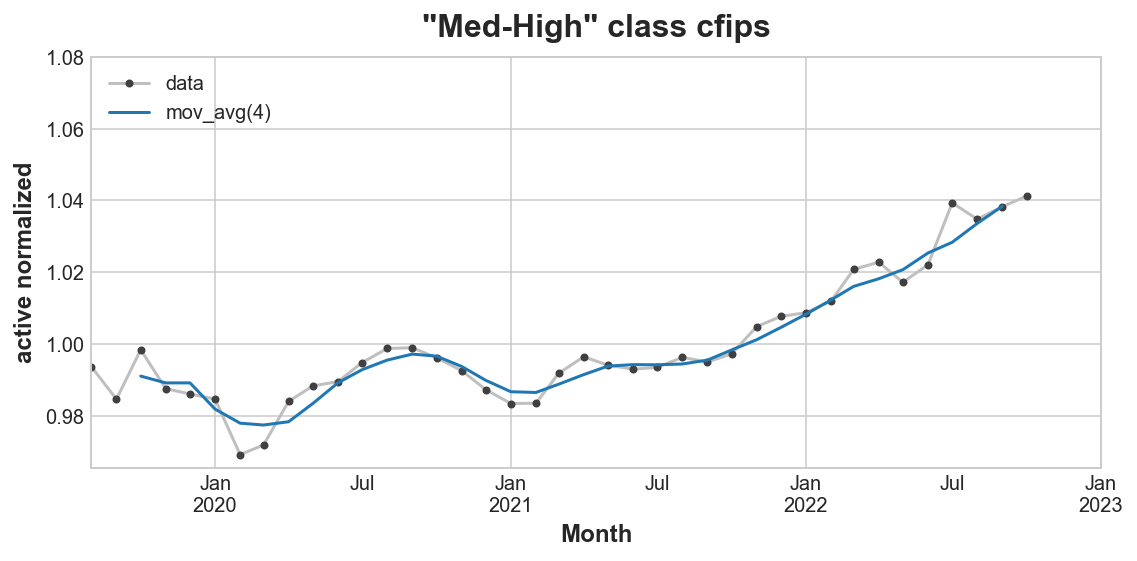

In [51]:
# filter the high class cfips in the train_df dataset, taking the time series of each them
ts_med_high = train_df[train_df['cfips'].isin(med_high.index)].copy()
ts_med_high['active_mean'] = ts_med_high.groupby('cfips')['active'].transform('mean')
ts_med_high['active_norm'] = ts_med_high['active'] / ts_med_high['active_mean']

ts_med_high.groupby('Month')['active_norm'].mean().plot(**plot_params, ylabel='active normalized', title='"Med-High" class cfips', label='data')
ts_med_high.groupby('Month')['active_norm'].mean().rolling(4, center=True).mean().plot(label='mov_avg(4)')
plt.xlim(None, '2023-01-01')
plt.ylim(None, 1.08)
plt.legend(loc='upper left');
print("Looking the consolidated plot, we see a clear upper trend (exponential or quadratic like), but no clear seasonality!")

#### R² linear_regression error

In [52]:
R2_error = []

for cfip in med_high.index:
    
    df = ts_med_high[ts_med_high['cfips'] == cfip]
    
    # Fit linear regression on the period of fev-2021 and forward
    x = np.arange(18,39).reshape(21,1)
    y = df['active'].iloc[18:]
    model = LinearRegression().fit(x, y)
    R2_error.append(model.score(x,y))

med_high['R2_error_fev2021'] = R2_error
med_high = med_high.sort_values('R2_error_fev2021', ascending=False)
med_high['group_type'] = pd.cut(med_high['R2_error_fev2021'], bins=[0, .8, 1], labels=['outlier', 'not_outlier'])
med_high['group_type'].value_counts()

outlier        596
not_outlier    316
Name: group_type, dtype: int64

In [54]:
dt = ts_med_high.groupby('cfips')['microbusiness_density'].mean().sort_values(ascending=False).copy()
med_high['microbusiness_density'] = med_high.index.map(dt)
df = med_high[['R2_error_fev2021','microbusiness_density']].sort_values('microbusiness_density', ascending=False)
df = df.loc[(df['R2_error_fev2021'] >= 0.7) & (df['microbusiness_density'] >= 4.0)]
df

,R2_error_fev2021,microbusiness_density
cfips,,
16021,0.994859,46.730638
32017,0.822713,40.140351
8097,0.900770,27.567022
8113,0.917796,22.461048
25019,0.776422,20.184157
...,...,...
54061,0.902196,4.033605
13145,0.872937,4.033114
20015,0.774795,4.012779


In [ ]:
dt = med_high.loc[med_high.R2_error_fev2021>=0.8]
dt.index[200:230]


In [ ]:
','.join([str(i) for i in dt.index])

#### Linear regression forecasting

In [ ]:
linreg_forecast = adj_linearregression_model(med_high, ts_med_high)
emp_vals, sub_df = sub_file(test_df, linreg_forecast)

# save submmission file
# sub_df.to_csv('./submission_files/submission_timedep_linregadj_high_255plus_v1.csv', header=True, sep=",", index=False)

print("Empty values in submission file: ", emp_vals)
sub_df.head(3)

#### Exponential Smoothing Forecast

In [ ]:
ets_forecast = clip_exp_smoothing_model(med_high, ts_med_high)
emp_vals, sub_df = sub_file(test_df, ets_forecast)

# save submmission file
# sub_df.to_csv('./submission_files/submission_timedep_ets-clip-high_255plus_v0.csv', header=True, sep=",", index=False)

print("Empty values in submission file: ", emp_vals)
sub_df.head()

#### Plot predictions

In [ ]:
# Plot forecasts
# for cfip in lista.index:
cfip = 42031
df = ts_med_high[ts_med_high['cfips'] == cfip]['active']
df.plot(**plot_params, ylabel='active', label='data', title=f'{cfip}')
df.rolling(4, center=True).mean().plot(style='-', label='mov_avg')
linreg_forecast[cfip].plot(color='C1', style='.-', label='linreg_fore')
ets_forecast[cfip].plot(color='C5', style='.-', label='ets_fore_DirecRec')
plt.legend()
plt.show();

In [ ]:
# errors between linreg and ets_add_true_none forecasts. Represents the difference between long trend (linreg) and
# short trend (ets_add_true_none)
print("As the smaller number of ")
med_high['norm_RMSE_lr_ets'] = [mean_squared_error(linreg_forecast[cfip], ets_forecast[cfip], squared=False)/(linreg_forecast[cfip] + ets_forecast[cfip]).mean() for cfip in med_high.index]
med_high = med_high.sort_values('norm_RMSE_lr_ets', ascending=False)

log_RMSE = pd.Series(np.log(med_high['norm_RMSE_lr_ets'].values.flatten()), index=med_high['norm_RMSE_lr_ets'].index)

(log_mean, log_std) = (log_RMSE.mean(), log_RMSE.std())
print('(log_mean, log_std): ', (log_mean, log_std))

log_RMSE.plot(kind='hist', bins=41, figsize=(8,4), title='log_RMSE between linreg and ets')
plt.xlabel('log_RMSE')
plt.show();

In [ ]:
# 300 biggest RMSE cfips errors by hand
# for ets with parameters trend='add', damped_trend='True', seasonal=None
# ALL OUTLIER CFIPS THAT DON´T ARE IN THE LISTS BELOW, IS ets_add_true_none GROUP_TYPE
# specials cfips (model between linreg and ets): 18073, 48053, 21215, 26103, 53065, 48221, 37109, 24023, 51065, 6005, 48037,
# 19169, 6045, 5145, 1033, 18177, 6043, 40111, 18099, 42031, 41031, 37109, 42051, 51590, 19169, 40081, 8039, 21047, 1103,
# 17001, 45031, 51019, 36073, 16081, 51075, 20161, 8113, 42009, 42033, 35025, 26151, 35035, 42107, 20079, 40031, 18061,
# 29097, 20037, 36095, 51033, 21083, 24019, 18095, 51109, 54037, 36031, 13133, 47147, 23025, 48459, 13179, 12023, 40071,
# 53049, 12075, 39033, 39101, 8085, 22005, 39063, 51001, 41015, 26155, 37195, 36003, 23007, 37093, 47089, 49021, 55141,
# 51610, 22101, 55021, 26165, 51127, 17105, 8049, 18151, 48299, 29101, 31157, 21035, 4007, 21059, 37039, 23015, 26111,
# 30013,6047, 29051, 18059, 36077, 13115, 48361, 36057, 21205, 47003, 36053
linreg_out_list = [18073, 48053, 6115, 21215, 26103, 27035, 53007, 37109, 47103, 5145, 1033, 6043, 41031, 42051,
                   19169, 40081, 20161, 35025, 26151, 18061, 29097, 36095, 21083, 24019, 51109, 36031, 13133, 23025, 13179,
                   12023, 40071, 53049, 39101, 54055, 37155, 22005, 51001, 37195, 36003, 23007, 37093, 49021, 55141, 51063,
                   39173, 1113, 47063, 51145, 17179, 48373, 45037, 13013, 41011, 37069, 37037, 37105, 12129, 51800, 45043,
                   47073, 17049, 36019, 42001, 48299, 47053, 17077, 51570, 36035, 27017, 37181, 45085, 13313, 45055, 32023,
                   28087, 13137, 13255, 12119, 21209, 48019, 26089, 50021, 23015, 26111, 30013, 23017, 16011, 19033, 28075,
                   37189, 51099, 36105, 41019, 42063, 51125, 21205, 13009, 37107, 46083, 37047, 51790, 29091, 48477, 24001,
                   48099]
last_value_out_list = [51065, 48037, 6045, 18177, 39159, 42031, 51590, 21047, 1103, 45031, 51019, 36073, 16081,
                       8113, 42009, 42033, 35035, 42107, 20079, 40031, 20037, 54107, 18095, 54037, 47147, 48459, 12075, 39033,
                       8085, 39063, 41015, 26155, 47089, 51610, 22101, 55021, 26165, 51127, 17105, 8049, 18151, 29101, 31157,
                       21035, 4007, 21059, 37039, 29051, 36077, 13115, 48361, 36057, 36053]

linreg_out_dic = dict(zip(linreg_out_list, ['linreg']*len(linreg_out_list)))
last_value_out_dic = dict(zip(last_value_out_list, ['last_value']*len(last_value_out_list)))

# # # create the column with the better model to use in forecasting
med_high['model'] = med_high.index.map({**linreg_out_dic, **last_value_out_dic})
med_high['model'] = med_high['model'].fillna('ets_add_true_none')


In [ ]:
print(med_high['model'].value_counts())
med_high.head(5)

### 4 - "Med_Low" class forecasting

#### Previous Analysis

In [ ]:
med_low = active_grouped[active_grouped['class'] == 'med_low'].sort_values(by='active', ascending=False)
print('med_low shape: ', med_low.shape)
med_low.head(3)

In [ ]:
# filter the high class cfips in the train_df dataset, taking the time series of each them
ts_med_low = train_df[train_df['cfips'].isin(med_low.index)].copy()
ts_med_low['active_mean'] = ts_med_low.groupby('cfips')['active'].transform('mean')
ts_med_low['active_norm'] = ts_med_low['active'] / ts_med_low['active_mean']

ts_med_low.groupby('Month')['active_norm'].mean().plot(**plot_params, ylabel='active normalized', title='"Med-Low" class cfips', label='data')
ts_med_low.groupby('Month')['active_norm'].mean().rolling(4, center=True).mean().plot(label='mov_avg(4)')
plt.xlim(None, '2023-01-01')
plt.ylim(None, 1.08)
plt.legend(loc='upper left');
print("Looking the consolidated plot, we see a clear upper trend (exponential or quadratic like), but again, no clear seasonality!")

#### Linear regression forecasting

In [ ]:
linreg_forecast = adj_linearregression_model(med_low, ts_med_low)
emp_vals, sub_df = sub_file(test_df, linreg_forecast)

# save submmission file
# sub_df.to_csv('./submission_files/submission_timedep_linregadj_medlow_v1.csv', header=True, sep=",", index=False)

print("Empty values in submission file: ", emp_vals)
sub_df.head(3)

#### Exponential Smoothing forecasting

In [ ]:
ets_forecast = clip_exp_smoothing_model(med_low, ts_med_low)
emp_vals, sub_df = sub_file(test_df, ets_forecast)

# save submmission file
# sub_df.to_csv('./submission_files/submission_timedep_ets_medlow_v1.csv', header=True, sep=",", index=False)

print("Empty values in submission file: ", emp_vals)
sub_df.head(3)

#### Plot predictions

In [ ]:
# errors between linreg and ets_add_true_none forecasts. Represents the difference between long trend (linreg) and
# short trend (ets_add_true_none)
print("As the smaller number of active business, higher will be the RMSE error!")
med_low['norm_RMSE_lr_ets'] = [mean_squared_error(linreg_forecast[cfip], ets_forecast[cfip], squared=False) / \
                               (linreg_forecast[cfip] + ets_forecast[cfip]).mean() \
                               for cfip in med_low.index]

med_low = med_low.sort_values('norm_RMSE_lr_ets', ascending=False)

log_RMSE = pd.Series(data = np.log(med_low['norm_RMSE_lr_ets'].values.flatten()),
                     index = med_low['norm_RMSE_lr_ets'].index)

(log_mean, log_std) = (log_RMSE.mean(), log_RMSE.std())
print(f'log_mean: {log_mean}', f'\nlog_std: {log_std}')

# Plot
log_RMSE.plot(kind='hist', bins=41, figsize=(8,4), title='log_RMSE between linreg and ets', xlabel='log_RMSE')
plt.show();

In [ ]:
# divide the cfips in outliers and not_outliers
med_low['group_type'] = pd.cut(med_low['norm_RMSE_lr_ets'],
                               bins=[0, np.exp(log_mean + 0.5 * log_std), np.inf],
                               labels=['not_outlier', 'outlier'])

med_low['group_type'].value_counts()

In [ ]:
lista = med_low.iloc[:10]

In [ ]:
# 400 biggest RMSE cfips errors by hand
# for ets with parameters trend='add', damped_trend='True', seasonal=None
# ALL OUTLIER CFIPS THAT DON´T ARE IN THE LISTS BELOW, IS ets_add_true_none GROUP_TYPE
# specials cfips (model between linreg and ets): 
linreg_out_list = []
last_value_out_list = []

In [ ]:
# Plot forecasts
for cfip in lista.index:
    #cfip = 48145
    df = ts_med_low[ts_med_low['cfips'] == cfip]['active']
    df.plot(**plot_params, ylabel='active', label='data', title=f'{cfip}')
    df.rolling(4, center=True).mean().plot(style='-', label='mov_avg')
    linreg_forecast[cfip].plot(color='C1', style='.-', label='linreg_fore')
    ets_forecast[cfip].plot(color='C5', style='.-', label='ets_fore_DirecRec')
    plt.legend()
    plt.show();

### Single case Linear Regression

#### Lag time series

In [ ]:
cfip = 1001
ts = pd.DataFrame(train_pivoted[cfip])
y = ts.copy()
X = ts.copy()
X['lag_1'] = X[cfip].shift(1)
X['lag_2'] = X[cfip].shift(2)
X['lag_3'] = X[cfip].shift(3)
X['lag_4'] = X[cfip].shift(4)

X = X.dropna().drop(cfip, axis=1)
X.head()

In [ ]:
y_train, X_train = y.align(X, join='inner', axis=0)

# features lags to make forecast
X_pred = ts.iloc[-4:, :].sort_index(ascending=False).values.T

# set period to forecast
X_pred_period = pd.date_range(start="2022-11", end="2022-11", periods=None, freq="MS").to_period("D")
X_pred_period.name = "Month"


In [ ]:
y_train.head()

In [ ]:
X_train.tail()

#### Linear regression model

In [ ]:
model = LinearRegression().fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=y_train.index, columns=y_train.columns)
y_pred = pd.DataFrame(model.predict(X_pred), index=X_pred_period, columns=y_train.columns).clip(0.0)
y_fit_single = y_fit.copy()


In [ ]:
y_pred

In [ ]:
axs = y_train.plot(color='C0', subplots=True, sharex=True, style='.-', label='y_true')
axs = y_fit.plot(color='C1', subplots=True, sharex=True, ax=axs, style='.-', label='y_fit')
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs, style='.-', label='y_fit')
for ax in axs:
    ax.legend()
    ax.set_xlim(right='2023-01-01')
_ = plt.suptitle(f"Linear regression - cfip {cfip}")

### Multiple Iteration Linear Regression

In [ ]:
# number of lags to use in X_train
nlags = 1

# number of steps between forecast origin and forecast horizon
nlead_time = 1

# number of forecast values to predict
nsteps = 1


In [ ]:
# setup the feature dataframe with the corresponding lags and lead time
def make_lags(ts, nlags, lead_time):
    
    return pd.concat({f'y_lag_{lag}': ts.shift(lag) for lag in range(lead_time, nlags + lead_time)}, axis=1)


In [ ]:
# dataframe with fitted values from training set
train_fitted = pd.DataFrame(index=train_pivoted.index[nlags:], columns=train_pivoted.columns)

# set period to forecast
X_pred_period = pd.date_range(start="2022-11", end="2022-11", freq="MS").to_period("D")
X_pred_period.name = "Month"

# dataframe with forecasteds values
pred_forecast = pd.DataFrame(index=X_pred_period, columns=train_pivoted.columns)

for cfip in list(train_pivoted.columns):

    # cfip time series
    y = pd.concat([train_pivoted[cfip], econ_rates], axis=1)
    
    # make lags
    X = make_lags(y, nlags, nlead_time).dropna()
    
    # fit the time series (y) to match X
    y_train, X_train = y.align(X, join='inner', axis=0)
    y_train = y_train.drop(['cpi_12M_pct_var', 'unemployment_rate_us', '10y_treasury_rate'], axis=1).squeeze()
    
    # features lags to make forecast
    X_pred = y.iloc[-nlags:, :].sort_index(ascending=False).values.flatten().reshape(1,4)
    
    # model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    train_fitted[cfip] = model.predict(X_train)
    pred_forecast[cfip] = model.predict(X_pred)
    
# set negative forecasts to 0
train_fitted = train_fitted.clip(0.0)
pred_forecast.clip(lower=0.0, upper=np.inf, inplace=True)

In [ ]:
pred_forecast

In [ ]:
cfip = 1003
axs = train_pivoted[cfip].plot(color='C0', subplots=True, sharex=True, style='.-', label='y_true')
axs = train_fitted[cfip].plot(color='C3', subplots=True, sharex=True, ax=axs, style='.-', label='y_fit')
axs = pred_forecast[cfip].plot(color='C2', subplots=True, sharex=True, ax=axs, style='.-', label='y_pred')
for ax in axs:
    ax.legend()
    ax.set_xlim(right='2023-01-01')
_ = plt.suptitle(f"Linear regression - cfip {cfip}")

#### Submission file

In [ ]:
def sub_file(sample_sub_df, df_pred):
    
    df_pred = pd.concat({'microbusiness_density': df_pred}, names=[None, 'cfips'], axis=1)
    df_pred = df_pred.stack().reset_index()
    
    df_pred["Month"] = df_pred["Month"].astype(str)
    df_pred["cfips"] = df_pred["cfips"].astype(str)
    df_pred["row_id"] = df_pred["cfips"] + "_" + df_pred["Month"]    
    df_pred = df_pred.drop(["Month", "cfips"], axis=1).reindex(columns=sample_sub_df.columns)
    
    sub_file_final = sample_sub_df.drop("microbusiness_density", axis=1).merge(df_pred, how="left", on="row_id")
    sub_file_final = sub_file_final.fillna(0.0)
    empty_values = sub_file_final.isna().sum().sum()
    
    return empty_values, sub_file_final

emp_vals, sub_df = sub_file(samp_sub_df, pred_forecast)

# save submmission file
sub_df.to_csv('./submission_files/submission_Direct_linreg_serial_v3.csv', header=True, sep=",", index=False)

print("Empty values in submission file: ", emp_vals)




In [ ]:
sub_df.head(3)

#### SMAPE

In [ ]:
# calculate SMAPE between forecasts and actual values
def smape(ts_true, ts_pred):
    
    y_true = ts_true.values.reshape(-1)
    y_pred = ts_pred.values.reshape(-1)
    numerator = 2 * np.abs(y_true - y_pred)
    denominator = np.abs(y_pred) + np.abs(y_true)
        
    df = pd.DataFrame(index=range(max(numerator.shape)), columns=["Numerator", "Denominator"])
    df["Numerator"] = numerator.T
    df["Denominator"] = denominator.T
    
    df = df[df["Denominator"] != 0.0]   # Drop rows where column "Denominator" is equal to 0

    return 100 * np.mean(df["Numerator"].values/df["Denominator"].values)

In [ ]:
smape(train_pivoted.iloc[1:,:],train_fitted)

### Multiple Stacked Linear Regression

In [ ]:
# number of lags to use in X_train
nlags = 4

# number of steps between forecast origin and forecast horizon
nlead_time = 1

# number of forecast values to predict
nsteps = 1


In [ ]:
# setup the feature dataframe with the corresponding lags and lead time
def make_lags(ts, nlags, lead_time):
    
    return pd.concat({f'y_lag_{lag}': ts.shift(lag) for lag in range(lead_time, nlags + lead_time)}, axis=1)


In [ ]:
# Four weeks of lag features
y = train_pivoted.iloc[:, :3]
X = make_lags(y, nlags, nlead_time).dropna()
display(y.head())
X.head()

# y = train_pivoted.copy()
# X = make_lags(y, nlags, nlead_time).fillna(0.0)
# display(y.head())
# X.head()

In [ ]:
# setup the dataframe with the corresponding shifs steps
def make_multistep_target(ts, nsteps):
    
    return pd.concat({f'y_step_{i}': ts.shift(-i) for i in range(nsteps)}, axis=1)


In [ ]:
# 1-Month forecast
y = make_multistep_target(y, nsteps).dropna()
print("y multistep (forecast horizon): ")
display(y)

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)
print("\ny align: ")
display(y)
print("\nX align: ")
X


# # 1-Month forecast
# y = make_multistep_target(y, nsteps).dropna()
# print("y multistep (forecast horizon): ")
# display(y.tail())

# # Shifting has created indexes that don't match. Only keep times for
# # which we have both targets and features.
# y, X = y.align(X, join='inner', axis=0)
# print("\ny align: ")
# display(y.tail())
# print("\nX align: ")
# X.tail()

#### Stacking training dataframes

In [ ]:
le = LabelEncoder()

X_train = X.stack("cfips").reset_index("cfips")   # wide to long
# X_train["cfips"] = le.fit_transform(X_train["cfips"])

y_train = y.stack('cfips')  # wide to long

display(X_train)
display(y_train)

#### Linear Regression Model

In [ ]:
# Create splits
model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=y_train.index, columns=y_train.columns)
y_fit_mul = y_fit.copy()

In [ ]:
y_fit_mul

In [ ]:
U = y_fit_mul.reset_index('cfips')
fit_mul = U[U.cfips == 1005].drop('cfips', axis=1)
fit_mul

In [ ]:
axs = train_pivoted[1005].plot(color='C0', subplots=True, sharex=True, style='.-', label='y_true')
axs = y_fit_single.plot(color='C1', subplots=True, sharex=True, ax=axs, style='.-', label='y_fit')
axs = fit_mul.plot(color='C3', subplots=True, sharex=True, ax=axs, style='.-', label='y_fit')
for ax in axs:
    ax.legend()
    ax.set_xlim(right='2023-01-01')
_ = plt.suptitle(f"Linear regression - cfip {cfip}")